In [ ]:
# Uninstall the current version of TensorFlow
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
# Install TensorFlow 2.12
!pip install tensorflow==2.12

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninsta

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
import os
import re
import cv2
import time
import tarfile
import datetime
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow import concat
from tensorflow import repeat
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from skimage.transform import resize
import nltk.translate.bleu_score as bleu
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import expand_dims
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Layer, Dropout, GRU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = np.load('/content/drive/MyDrive/Major_Project/Data/train.npy',allow_pickle=True)
test = np.load('/content/drive/MyDrive/Major_Project/Data/test.npy',allow_pickle=True)
validation = np.load('/content/drive/MyDrive/Major_Project/Data/validation.npy',allow_pickle=True)

In [ ]:
columns = ["front X-Ray", "lateral X-Ray", "findings", "dec_ip", "dec_op", "image_features"]

train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns)
validation = pd.DataFrame(validation, columns = columns)

In [ ]:
# Reshaping the image feature tensors for training
train_image_features = np.vstack(train.image_features).astype(np.float64)
validation_image_features = np.vstack(validation.image_features).astype(np.float64)

In [ ]:
image_model = DenseNet121(weights='/content/drive/MyDrive/Major_Project/Model/brucechou1983_CheXNet_Keras_0.3.0_weights.h5', classes = 14, input_shape=(256,256,3))
model = Model(image_model.input, image_model.layers[-2].output)

In [ ]:
token = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train['findings'])

token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
vocab_size = len(token.word_index) + 1
print('Vocab size - ', vocab_size)

#sequence in train and validation
train_inp_dec = token.texts_to_sequences(train.dec_ip)
train_op_dec = token.texts_to_sequences(train.dec_op)
val_inp_dec = token.texts_to_sequences(validation.dec_ip)
val_op_dec = token.texts_to_sequences(validation.dec_op)

#padding in the train and validation
max_len = 100
decoder_input = pad_sequences(train_inp_dec, maxlen=max_len, padding='post')
decoder_output =  pad_sequences(train_op_dec, maxlen=max_len, padding='post')
Validation_decoder_input = pad_sequences(val_inp_dec, maxlen=max_len, padding='post')
Validation_decoder_output = pad_sequences(val_op_dec, maxlen=max_len, padding='post')
print(decoder_input[:1])

word_idx = {}
idx_word = {}
for key, value in (token.word_index).items():
    word_idx[key] = value
    idx_word[value] = key

Vocab size -  1447
[[  5  99  16   4  20   8 103 143 214  55  87   3  79  22   1  29  62  70
   15   8  38   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


In [ ]:
batch_size     = 50
Buffer_size    = 500

train_dataset = tf.data.Dataset.from_tensor_slices(((train_image_features, decoder_input), decoder_output))
train_dataset = train_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_image_features,Validation_decoder_input),Validation_decoder_output))
validation_dataset = validation_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Writing Encoder :

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,lstm_units):
        super().__init__()

        self.lstm_units = lstm_units
        self.dense      = Dense(self.lstm_units, kernel_initializer="glorot_uniform", name = 'encoder_dense_layer')

    def initialize_states(self,batch_size):

      self.batch_size  = batch_size
      self.enc_h       = tf.zeros((self.batch_size, self.lstm_units))

      return self.enc_h

    def call(self,x):

      # x : image_data
      encoder_output = self.dense(x)

      return encoder_output

## Writing Attention :

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class that calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,attention_units):
    super().__init__()

    self.attention_units = attention_units

    self.w1_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w1_Dense')
    self.w2_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w2_Dense')
    self.Concat_Dense=  tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name = 'Concat_Dense_layer')

  def call(self,x):

    self.decoder_hidden_state, self.encoder_output = x
    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)

    score = self.Concat_Dense(tf.nn.tanh(self.w1_Dense(self.decoder_hidden_state) + self.w2_Dense(self.encoder_output)))

    att_weights    = tf.nn.softmax(score, axis=1)
    context_vector = att_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector,att_weights

## Writing Onestepdecoder :

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
      super().__init__()

      self.lstm_units     = lstm_units
      self.vocab_size     = vocab_size
      self.embedding_dim  = embedding_dim
      self.attention_units= attention_units

      self.dense       = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name ='onestep_dense')
      self.attention   = Attention( self.attention_units)
      self.decoder_emb = Embedding(self.vocab_size, self.embedding_dim, trainable = True , name = 'Decoder_embedding')
      self.decoder_gru = GRU(self.lstm_units, return_state=True, return_sequences=True, name="Decoder_LSTM")


      self.dropout1 = Dropout(0.3,name = 'dropout1')
      self.dropout2 = Dropout(0.3,name = 'dropout2')
      self.dropout3 = Dropout(0.3,name = 'dropout3')

  @tf.function
  def call(self,x,training=None):

    self.input_to_decoder, self.encoder_output, self.state_h = x

    embedded_output = self.decoder_emb(self.input_to_decoder)
    embedded_output = self.dropout1(embedded_output)

    y = [self.state_h,self.encoder_output]
    context_vector, att_weights = self.attention(y)

    concated_decoder_input = tf.concat([tf.expand_dims(context_vector, 1),embedded_output], -1)
    concated_decoder_input = self.dropout2(concated_decoder_input)

    output_gru, hidden_state = self.decoder_gru(concated_decoder_input, initial_state=self.state_h)

    output_gru = tf.reshape(output_gru, (-1, output_gru.shape[2]))
    output_gru = self.dropout3(output_gru)

    output = self.dense(output_gru)

    return output,hidden_state,att_weights,context_vector

## Writing Decoder :

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
      super().__init__()

      self.lstm_units     = lstm_units
      self.vocab_size     = vocab_size
      self.embedding_dim  = embedding_dim
      self.attention_units= attention_units

      self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.lstm_units, self.attention_units)

    @tf.function
    def call(self, x,training=None):

        self.input_to_decoder, self.encoder_output, self.decoder_hidden_state = x
        all_outputs = tf.TensorArray(tf.float32,size = self.input_to_decoder.shape[1], name = 'output_arrays' )

        for timestep in tf.range(self.input_to_decoder.shape[1]):

          y = [self.input_to_decoder[:,timestep:timestep+1],self.encoder_output, self.decoder_hidden_state]
          output,hidden_state,att_weights,context_vector = self.onestepdecoder(y)

          self.decoder_hidden_state = hidden_state
          all_outputs = all_outputs.write(timestep,output)

        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])

        return all_outputs

## Encoder-Decoder Model :

In [ ]:
class Encoder_decoder(tf.keras.Model):
  """
     # Intialize encoder states, Pass the encoder_sequence to the embedding layer
     # Decoder initial states are encoder final states, Initialize it accordingly
     # Pass the decoder sequence,encoder_output,decoder states to Decoder
     # return the decoder output

  """
  def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units, batch_size):
        super().__init__()

        self.vocab_size     = vocab_size
        self.batch_size     = batch_size
        self.lstm_units     = lstm_units
        self.embedding_dim  = embedding_dim
        self.attention_units= attention_units

        self.encoder = Encoder(self.lstm_units)
        self.decoder = Decoder(vocab_size, embedding_dim, lstm_units, attention_units)
        self.dense   = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name = 'enc_dec_dense')



  def call(self,data):

    self.inputs, self.outputs = data[0], data[1]

    self.encoder_hidden = self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)

    x = [self.outputs,self.encoder_output,self.encoder_hidden]
    output = self.decoder(x)

    return output

## Writing Custom loss function :

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Load Encoder-Decoder Model :**

In [ ]:
lstm_units     = 256
embedding_dim  = 300
attention_units= 64
tf.keras.backend.clear_session()
Attention_model = Encoder_decoder(vocab_size,embedding_dim,lstm_units,attention_units,batch_size)
Attention_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)
Attention_model.fit(train_dataset, validation_data=validation_dataset, epochs=1, shuffle=True)

64/64 [==============================] - 221s 3s/step - loss: 1.4277 - val_loss: 1.3866


**Loading best pre-trained weights :**

In [ ]:
Attention_model.load_weights('/content/drive/MyDrive/Attention_model03.h5')

**Prediction : Beam Search AND Inference : Model Evaluation & Image Plotting**

In [ ]:
def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (256,256,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)

  return X

def preprocess(image1_paths,image2_paths):

  '''
    input -- dataframe(df)
    output -- dataframe(df)
    process - convert images into 256 X 256, then using CHeXNET model generate tensor(concate two image tensor)

  '''
  path = '/content/drive/MyDrive/NLMCXR_images/'

  image_features = []
  for i in range(len(image1_paths)):

    i1 = load_image(path+image1_paths)
    i2 = load_image(path+image2_paths)
    img1_features = model.predict(i1)
    img2_features = model.predict(i2)
    img1_features = np.vstack(img1_features).astype(np.float)
    img2_features = np.vstack(img2_features).astype(np.float)

    tensor = np.concatenate((img1_features, img2_features), axis=1)

  return tensor, img1_features, img2_features

#Refrence : https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

def evaluate(image1, image2):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function takes images and using encoder decoder model
    return medical report of the images
    The function predicts the sentence using beam search

    '''

    img_tensor , img1_features, img2_features = preprocess(image1, image2)
    image_features = np.vstack(img_tensor).astype(np.float)

    result = ''
    initial_state  = Attention_model.layers[0].initialize_states(1)
    sequences      = [['<start>', initial_state, 0]]

    encoder_output       = Attention_model.layers[0](image_features)
    decoder_hidden_state = initial_state

    max_len = 75
    beam_width = 3
    finished_seq = []

    for i in range(max_len):
        new_seq = []
        all_probable = []

        for seq,state,score in sequences:

            cur_vec = np.reshape(word_idx[seq.split(" ")[-1]],(1,1))
            decoder_hidden_state = state
            x = [cur_vec, encoder_output, decoder_hidden_state]
            output,hidden_state,att_weights,context_vector = Attention_model.get_layer('decoder').onestepdecoder(x)
            output = tf.nn.softmax(output)
            top_words = np.argsort(output).flatten()[-beam_width:]
            for index in top_words:

                predicted = [seq + ' '+ idx_word[index], hidden_state, score-np.log(np.array(output).flatten()[index])]
                all_probable.append(predicted)

        sequences = sorted(all_probable, key = lambda l: l[2])[:beam_width]

        count = 0
        for seq,state,score in sequences:
            if seq.split(" ")[-1] == '<end>':
                score = score/len(seq)
                finished_seq.append([seq,state,score])
                count+=1
            else:
                new_seq.append([seq,state,score])

        sequences = new_seq
        beam_width= beam_width - count
        if not sequences:
            break
        else:
            continue

    if len(finished_seq) >0:
          finished_seq = sorted(finished_seq, reverse=True, key = lambda l: l[2])
          sequences = finished_seq[-1]
          return sequences[0][8:]
    else:
          return new_seq[-1][0]

def Predict_Caption(img_data):

    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context

    '''
    path = '/content/drive/MyDrive/NLMCXR_images/'

    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    result = evaluate(img_data[0],img_data[1])
    # Tokenize both actual and predicted reports
    actual_tokens = img_data[2].lower().split()  # Tokenize actual report
    predicted_tokens = result.lower().split()      # Tokenize predicted report

    # Calculate BLEU-1 (1-gram BLEU score)
    bleu_score = sentence_bleu([actual_tokens], predicted_tokens, weights=(1, 0, 0, 0))
    print(f"Images: {img_data[0]}, {img_data[1]}")
    print("Predicted Report :",result)
    print('BLEU Score:', bleu_score, '\n')
    # print('BLEU Score :-',sentence_bleu(img_data[2], result),'\n')

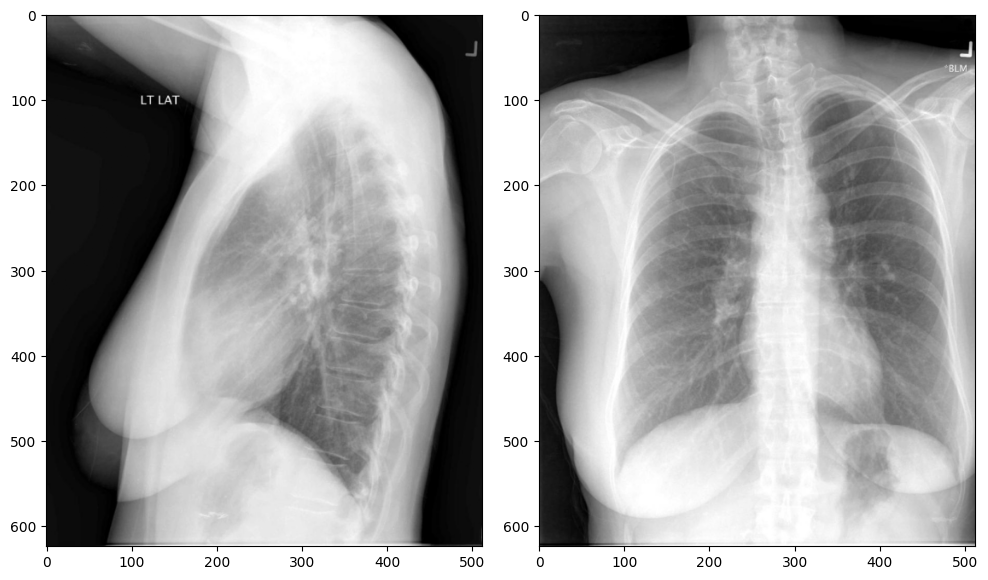

1/1 [==============================] - 0s 241ms/step
Images: CXR291_IM-1313-2001.png, CXR291_IM-1313-1001.png
Predicted Report : heart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits no focal consolidation suspicious pulmonary opacity pneumothorax or definite pleural effusion visualized osseous structures appear intact <end>
BLEU Score: 0.40625 

CPU times: user 26.4 s, sys: 1.37 s, total: 27.8 s
Wall time: 24 s


In [ ]:
%%time
Predict_Caption(test.values[63])

In [ ]:
for i, img_data in enumerate(test.values):
    print(f"Prediction for test sample {i + 1}:")
    Predict_Caption(img_data)
    print("-" * 50)  # Separator for readability

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%%time
Predict_Caption(test.values[63])

In [ ]:
# %%time
# for i in test.values[10:12]:
#     Predict_Caption(i)

In [ ]:
score_1 = 0
score_2 = 0
score_3 = 0
score_4 = 0

for i in range(test.shape[0]):
    image_1 = test['front X-Ray'][i]
    image_2 = test['lateral X-Ray'][i]

    # Get the model's result
    result = evaluate(image_1, image_2)

    # Get the reference (actual) report
    reference = test.findings[i]

    # Manual tokenization (lowercase and split by spaces)
    reference_tokens = reference.lower().split()  # Tokenize actual report
    result_tokens = result.lower().split()        # Tokenize predicted report

    # Calculate BLEU scores with different n-gram weights
    score_1 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(1, 0, 0, 0))  # BLEU1
    score_2 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(0.5, 0.5, 0, 0))  # BLEU2
    score_3 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(0.33, 0.33, 0.33, 0))  # BLEU3
    score_4 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU4

    # Print BLEU1 score for this iteration
    print("BLEU1 score in", i, "th iteration is:", score_1)

# Print the final BLEU scores averaged over the test set
print("Final Bleu1 score is : ", score_1 / test.shape[0])
print("Final Bleu2 score is : ", score_2 / test.shape[0])
print("Final Bleu3 score is : ", score_3 / test.shape[0])
print("Final Bleu4 score is : ", score_4 / test.shape[0])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 255ms/step
BLEU1 score in 297 th iteration is: 90.90055947616948
1/1 [==============================] - 0s 246ms/step
BLEU1 score in 298 th iteration is: 91.13575054835444
1/1 [==============================] - 0s 234ms/step
BLEU1 score in 299 th iteration is: 91.31432197692587
1/1 [==============================] - 0s 243ms/step
BLEU1 score in 300 th iteration is: 91.31889415524668
1/1 [==============================] - 0s 229ms/step
BLEU1 score in 301 th iteration is: 91.5291073705593
1/1 [==============================] - 0s 225ms/step
BLEU1 score in 302 th iteration is: 91.98704497053261
1/1 [==============================] - 0s 437ms/step
BLEU1 score in 303 th iteration is: 92.33292812057007
1/1 [==============================] - 0s 251ms/step
BLEU1 score in 304 th iteration is: 92.57668337078293
1/1 [==============================] - 0s 215ms/step
BLEU1 score in 305 th iteration is: 92.85

In [ ]:
print(test.shape[0])

In [ ]:
# score_1 = 0
# score_2 = 0
# score_3 = 0
# score_4 = 0

# for i in range(validation.shape[0]):
#     image_1 = validation['front X-Ray'][i]
#     image_2 = validation['lateral X-Ray'][i]

#     # Get the model's result
#     result = evaluate(image_1, image_2)

#     # Get the reference (actual) report
#     reference = validation.findings[i]

#     # Manual tokenization (lowercase and split by spaces)
#     reference_tokens = reference.lower().split()  # Tokenize actual report
#     result_tokens = result.lower().split()        # Tokenize predicted report

#     # Calculate BLEU scores with different n-gram weights
#     score_1 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(1, 0, 0, 0))  # BLEU1
#     score_2 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(0.5, 0.5, 0, 0))  # BLEU2
#     score_3 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(0.33, 0.33, 0.33, 0))  # BLEU3
#     score_4 += bleu.sentence_bleu([reference_tokens], result_tokens, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU4

#     # Print BLEU1 score for this iteration
#     print("BLEU1 score in", i, "th iteration is:", score_1)

# # Print the final BLEU scores averaged over the validation set
# print("Final Bleu1 score is : ", score_1 / validation.shape[0])
# print("Final Bleu2 score is : ", score_2 / validation.shape[0])
# print("Final Bleu3 score is : ", score_3 / validation.shape[0])
# print("Final Bleu4 score is : ", score_4 / validation.shape[0])

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cd6b4004a38f6cdaf969826ae06b85742981b2a4e85c8321c7481295c23be100
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

# Initialize cumulative scores
rouge1 = 0
rouge2 = 0
rougeL = 0

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i in range(test.shape[0]):
    image_1 = test['front X-Ray'][i]
    image_2 = test['lateral X-Ray'][i]

    # Get the model's generated report
    result = evaluate(image_1, image_2)

    # Get the reference (actual) report
    reference = test.findings[i]

    # Compute ROUGE scores
    scores = scorer.score(reference, result)

    rouge1 += scores['rouge1'].fmeasure
    rouge2 += scores['rouge2'].fmeasure
    rougeL += scores['rougeL'].fmeasure

    # Print ROUGE-1 score for this iteration
    print(f"ROUGE-1 score in {i}th iteration is: {scores['rouge1'].fmeasure}")

# Compute final averaged ROUGE scores
num_samples = test.shape[0]
print("Final ROUGE-1 score: ", rouge1 / num_samples)
print("Final ROUGE-2 score: ", rouge2 / num_samples)
print("Final ROUGE-L score: ", rougeL / num_samples)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 248ms/step
ROUGE-1 score in 297th iteration is: 0.5714285714285715
1/1 [==============================] - 0s 236ms/step
ROUGE-1 score in 298th iteration is: 0.3272727272727273
1/1 [==============================] - 0s 261ms/step
ROUGE-1 score in 299th iteration is: 0.3157894736842105
1/1 [==============================] - 0s 229ms/step
ROUGE-1 score in 300th iteration is: 0.2040816326530612
1/1 [==============================] - 0s 381ms/step
ROUGE-1 score in 301th iteration is: 0.24324324324324326
1/1 [==============================] - 0s 225ms/step
ROUGE-1 score in 302th iteration is: 0.5306122448979592
1/1 [==============================] - 0s 419ms/step
ROUGE-1 score in 303th iteration is: 0.47457627118644075
1/1 [==============================] - 0s 239ms/step
ROUGE-1 score in 304th iteration is: 0.31999999999999995
1/1 [==============================] - 0s 403ms/step
ROUGE-1 score in 305t

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but improves WordNet matching

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.translate.meteor_score import meteor_score

# Initialize METEOR score accumulator
meteor_total = 0

for i in range(test.shape[0]):
    image_1 = test['front X-Ray'][i]
    image_2 = test['lateral X-Ray'][i]

    # Get the model's result
    result = evaluate(image_1, image_2)

    # Get the reference (actual) report
    reference = test.findings[i]

    # Manual tokenization (lowercase and split by spaces)
    reference_tokens = reference.lower().split()  # Tokenize actual report
    result_tokens = result.lower().split()        # Tokenize predicted report

    # Compute METEOR score for this sample
    meteor = meteor_score([reference_tokens], result_tokens)
    meteor_total += meteor

    # Print METEOR score for this iteration
    print(f"METEOR score in {i}th iteration is: {meteor}")

# Compute and print the final average METEOR score
final_meteor = meteor_total / test.shape[0]
print("Final METEOR score is:", final_meteor)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 190ms/step
METEOR score in 50th iteration is: 0.16949152542372883
1/1 [==============================] - 0s 337ms/step
METEOR score in 51th iteration is: 0.4973907554974471
1/1 [==============================] - 0s 193ms/step
METEOR score in 52th iteration is: 0.3816793893129771
1/1 [==============================] - 0s 191ms/step
METEOR score in 53th iteration is: 0.1686311410459588
1/1 [==============================] - 0s 193ms/step
METEOR score in 54th iteration is: 0.044642857142857144
1/1 [==============================] - 0s 192ms/step
METEOR score in 55th iteration is: 0.16949152542372883
1/1 [==============================] - 0s 196ms/step
METEOR score in 56th iteration is: 0.3771131982204647
1/1 [==============================] - 0s 191ms/step
METEOR score in 57th iteration is: 0.16949152542372883
1/1 [==============================] - 0s 210ms/step
METEOR score in 58th iteration is: 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [ ]:
# Ensure files module is available
import google.colab.files as files

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from google.colab import files

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load the image
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Load DenseNet121 with CheXNet weights
image_model = DenseNet121(weights=None, include_top=False, input_shape=(256, 256, 3))
image_model.load_weights('/content/drive/MyDrive/Major_Project/Model/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

# Select last convolutional layer dynamically
last_conv_layer_name = [layer.name for layer in image_model.layers if 'conv' in layer.name][-1]

# Create model for Grad-CAM
model = Model(inputs=image_model.input, outputs=[image_model.get_layer(last_conv_layer_name).output, image_model.output])

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index=None):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predictions = tf.convert_to_tensor(predictions)  # Ensure it's a tensor

        if class_index is None:
            class_index = tf.argmax(predictions[0])  # Get highest probability class

        loss = predictions[:, class_index]  # Select class score

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

superimposed_img = superimpose_heatmap(img_path, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Heatmap Overlay")
plt.axis("off")
plt.show()


Saving CXR1_1_IM-0001-4001.png to CXR1_1_IM-0001-4001 (9).png


ValueError: Layer count mismatch when loading weights from file. Model expected 241 layers, found 242 saved layers.

In [ ]:
for layer in model.layers:
    print(layer.name)

input_2
zero_padding2d_2
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_3
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3